In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing

### Functions definations

In [2]:
# str list --> float list
def str2flt(str_list):
    flt_list=[]
    for i in str_list:
        flt_list.append(float(i))
    return flt_list

# Calculate the distance between two atoms
def dis_calc(atom_co_1,atom_co_2):
    dis=np.sqrt((atom_co_1[0]-atom_co_2[0])**2+(atom_co_1[1]-atom_co_2[1])**2+(atom_co_1[2]-atom_co_2[2])**2)
    return dis

In [3]:
# Get the information of atoms' position from the CIF file 
def atom_info_grep(data_file_name):
    # Initialization
    atom_info_list=[]
    C_cat_i, O_cat_i, Mg_cat_i = 0, 0, 0
    H_h2_i = 0
    with open(data_file_name,'r') as f:
        for line in f.readlines()[2:]:
            line_content=line.split()
            atom_type=line_content[0]
            # Get positions of catecholate atoms
            if atom_type=='C_cat':
                atome_name=atom_type+'_'+str(C_cat_i)
                atom_info_list.append([atome_name,atom_type]+line_content[1:])
                C_cat_i+=1
            elif atom_type=='O_cat':
                atome_name=atom_type+'_'+str(O_cat_i)
                atom_info_list.append([atome_name,atom_type]+line_content[1:])
                O_cat_i+=1
            elif atom_type=='Mg_cat':
                atome_name=atom_type+'_'+str(Mg_cat_i)
                atom_info_list.append([atome_name,atom_type]+line_content[1:])
                Mg_cat_i+=1
            # Get positions of H2 molecule
            elif atom_type=='H_h2':
                atome_name=atom_type+'_'+str(H_h2_i)
                atom_info_list.append([atome_name,atom_type]+line_content[1:])
                H_h2_i+=1
    return atom_info_list
    
# Make a list of the distance between the H atoms in H2 molecule and other atoms in the catecholate
def atom_distance_calc(atom_info_list):
    H_1_co=str2flt(atom_info_list[-2][2:])
    H_2_co=str2flt(atom_info_list[-1][2:])
    atom_distance_list=[]
    for atom_info_line in atom_info_list[:-2]:
        atom_co=str2flt(atom_info_line[2:])
        dis_1=dis_calc(H_1_co,atom_co)
        dis_2=dis_calc(H_2_co,atom_co)
        atom_type_1=atom_info_line[1]
        atom_distance_list.append([atom_type_1,'H_h2',dis_1])
        atom_distance_list.append([atom_type_1,'H_h2',dis_2])
    return atom_distance_list

In [4]:
# Equation of the Modified Morse potential
def mod_morse(r,D,ALPHA,r_star):
    return -kB*D*(1-(1-np.exp(-ALPHA*(r-r_star)))**2)

# Calculate the binding energy (mod-Morse)
def system_morse_energy_calc(morse_calc_list,morse_params):
    E_morse_sum=0
    for line in morse_calc_list:
        atom1_type = line[0]
        atom2_type = line[1]
        r = line[-1]
        if r > cutoff: continue
        else:
            if atom1_type == 'Mg_cat': E_morse = mod_morse(r,morse_params[0][0],morse_params[0][1],morse_params[0][2])
            elif atom1_type == 'C_cat': E_morse = mod_morse(r,morse_params[1][0],morse_params[1][1],morse_params[1][2])
            elif atom1_type == 'O_cat': E_morse = mod_morse(r,morse_params[2][0],morse_params[2][1],morse_params[2][2])
            E_morse_sum+=E_morse
    return E_morse_sum

In [5]:
# The loss function for the optimization, for calculating the RMSE between the binding energy ...
# ... calculated by MP2 with the binding energy calculated from the force field parameters
def RMSE(morse_params):
    E_FF_err_sum=0
    count=0
#     for type_index in np.arange(0,9):    # Don't use all 9 types of configurations, exclude type 4/5/7 -- CY, Jan 11 2023
    for type_index in [0,1,2,3,6,8]:
        if type_index==3: left_index=21
        elif type_index==6: 
            if site_type=='single': left_index=21
            elif site_type=='two': left_index=22
        elif type_index==8: left_index=19
        else: left_index=18
        for conj_index in np.arange(left_index,left_index+26):    # Considering not use all points
            struc_name = 'type'+str(type_index)+'_'+str(conj_index)
            E_MP2 = E_QM_all[E_QM_all['r'+str(type_index)]==(conj_index/10)]['E'+str(type_index)].values[0]
            E_LJ=xyz_file_E_LJ_all[xyz_file_E_LJ_all.struc_name==struc_name]['E_LJ_'+site_type].values[0]
            xyz_file_pwd=xyz_FILE_DIR_all+site_type+'_site/type'+str(type_index)+'/type'+str(type_index)+'_'+str(conj_index)+'.xyz'
            atom_info_list=atom_info_grep(xyz_file_pwd)
            atom_distance_info=atom_distance_calc(atom_info_list)
            E_morse=system_morse_energy_calc(atom_distance_info,morse_params)
            E_FF_err_sum+=((E_LJ+E_morse-E_MP2)**2)
            count+=1
    RMSE=np.sqrt(E_FF_err_sum/count)
    return RMSE
# This function NEED TO BE MODIFIED/OPTIMIZED since it takes too long for one loop (~20 ms)  --CY, Jan 11 2023

### __main__

In [6]:
site_type='two' # Difine the functionalized catecholate type, 'single' or 'two'

In [7]:
# Unit of the Energy: kJ/mol
kB=0.008314511
ke = 1389.354
cutoff = 12.8 # Å

# Loading the Binding Energy information
E_QM_all = pd.read_excel('../Energy.xlsx',sheet_name=site_type+'_MP2') # Binding energy calculated by MP2 
xyz_file_E_LJ_all=pd.read_csv('E_LJ_all.csv') # Binding energy calculated by LJ+Coulomb potential models
xyz_file_list=xyz_file_E_LJ_all.struc_name.values.tolist() # list of the XYZ files
xyz_FILE_DIR_all='data/' # XYZ files of different configurations (H2 + catecholate)

In [8]:
# Objective function for the optimization
def objective(v):
    x1, y1, z1,x2, y2, z2,x3, y3, z3 = v
    return RMSE([[x1, y1, z1],[x2, y2, z2],[x3, y3, z3]])

# Bounds for the optimization
D_min, D_max = 1.0, 1000.0
a_min, a_max = 0.01, 5.0
r_s_min, r_s_max = 0.1, 10.0
bounds = [[D_min,D_max],[a_min,a_max],[r_s_min,r_s_max],
          [D_min,D_max],[a_min,a_max],[r_s_min,r_s_max],
          [D_min,D_max],[a_min,a_max],[r_s_min,r_s_max]]

# Initial guess for the optimization
x_0 = [(D_min+D_max)/2,(a_min+a_max)/2,(r_s_min+r_s_max)/2,
      (D_min+D_max)/2,(a_min+a_max)/2,(r_s_min+r_s_max)/2,
      (D_min+D_max)/2,(a_min+a_max)/2,(r_s_min+r_s_max)/2]

In [21]:
# Dual Annealing
# result = dual_annealing(objective, bounds,maxiter=100000,x0=x_0,initial_temp=6000)
result = dual_annealing(objective, bounds,x0=x_0)
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : ['Maximum number of iteration reached']
Total Evaluations: 65851
Solution: f([801.05130105   2.05426003   2.25735546  30.05941461   1.5145476
   3.7782548    1.           0.91165539   6.39941212]) = 0.41214


### Figures

In [22]:
morse_params=[[solution[0],solution[1],solution[2]],[solution[3],solution[4],solution[5]],[solution[6],solution[7],solution[8]]]
RMSE(morse_params)

0.4121401568876562

In [23]:
morse_params_YSH_2=morse_params
morse_params_YSH_2

[[801.0513010450125, 2.0542600327586786, 2.25735546137502],
 [30.059414611273834, 1.5145475990264539, 3.7782548024240024],
 [1.0, 0.9116553908710805, 6.399412118481408]]

In [9]:
# YSH fitting result - single site
solution=[835.09, 2.014, 2.214, 
                10, 3.862, 2,
                10.021, 1.015, 4.986]

morse_params_YSH_1=[[solution[0],solution[1],solution[2]],[solution[3],solution[4],solution[5]],[solution[6],solution[7],solution[8]]]
RMSE(morse_params_YSH_1)

1.8166037904961374

In [10]:
# YSH fitting result - two site
solution=[641.414, 2.07, 2.249,
                10, 0.33, 8,
                10, 1.368, 4.3]

morse_params_YSH_2=[[solution[0],solution[1],solution[2]],[solution[3],solution[4],solution[5]],[solution[6],solution[7],solution[8]]]
RMSE(morse_params_YSH_2)

1.2270386176427959

In [14]:
# CY fitting result  (two-sites)-- Jan 08 2023
solution=[610.41446667,   1.77856029,   2.28918568,
          14.95903948,   1.54891844,   3.45540259,
          10.,           1.12647133,   4.65232994]

morse_params_CY_2=[[solution[0],solution[1],solution[2]],[solution[3],solution[4],solution[5]],[solution[6],solution[7],solution[8]]]
RMSE(morse_params_CY_2)

10.418420893603088

In [54]:
# Ref fitting result -- 10.1021/jp1094068
solution_s=[634.194, 2.055, 2.305, 
          13.567, 0.597, 6.336, 
          23.837, 1.321, 3.738]
morse_params_s=[[solution_s[0],solution_s[1],solution_s[2]],[solution_s[3],solution_s[4],solution_s[5]],[solution_s[6],solution_s[7],solution_s[8]]]
RMSE(morse_params_s)

1.485123219316029

In [117]:
morse_params_localmin=[[solution_localmin[0],solution_localmin[1],solution_localmin[2]],
                [solution_localmin[3],solution_localmin[4],solution_localmin[5]],
                [solution_localmin[6],solution_localmin[7],solution_localmin[8]]]

In [11]:
# Calculate the RMSE between two list (two set of numbers)
def RMSE_cal(list1,list2):
    if len(list1)==len(list2):
        sum_up=0
        for i in range(len(list1)):
            sum_up+=((list1[i]-list2[i])**2)
        return np.sqrt(sum_up/len(list1))

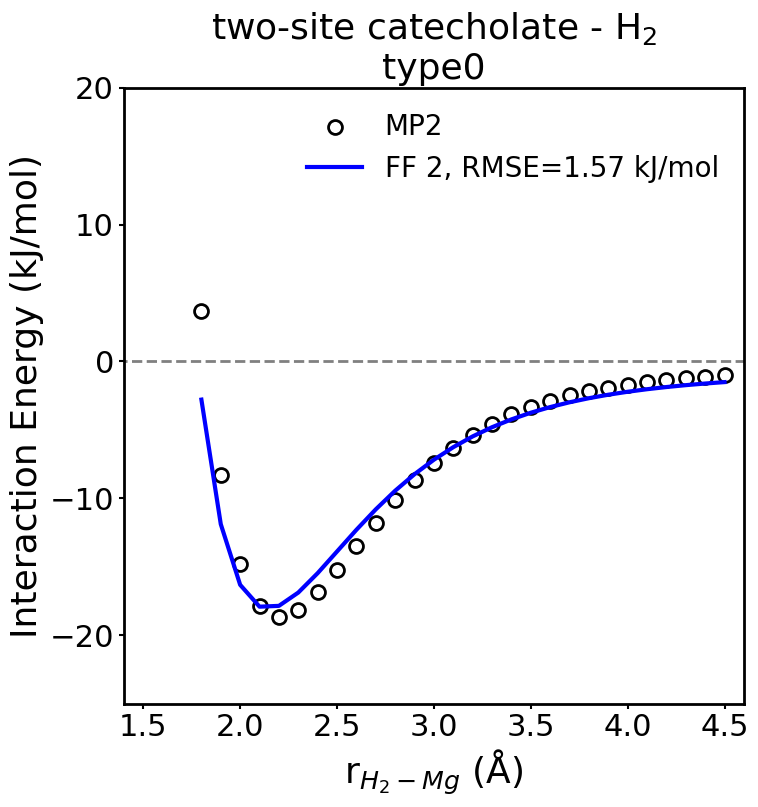

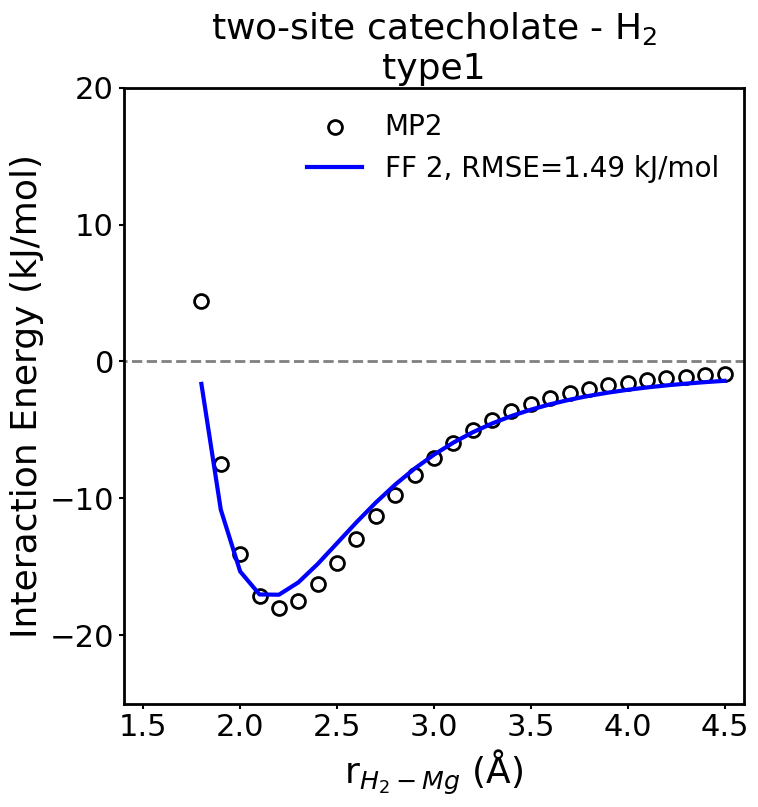

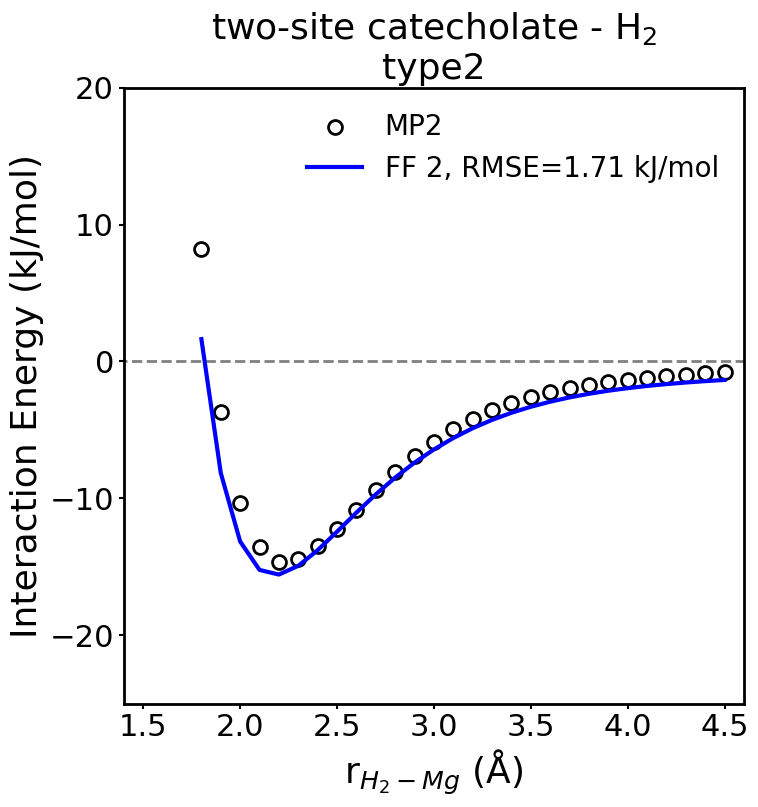

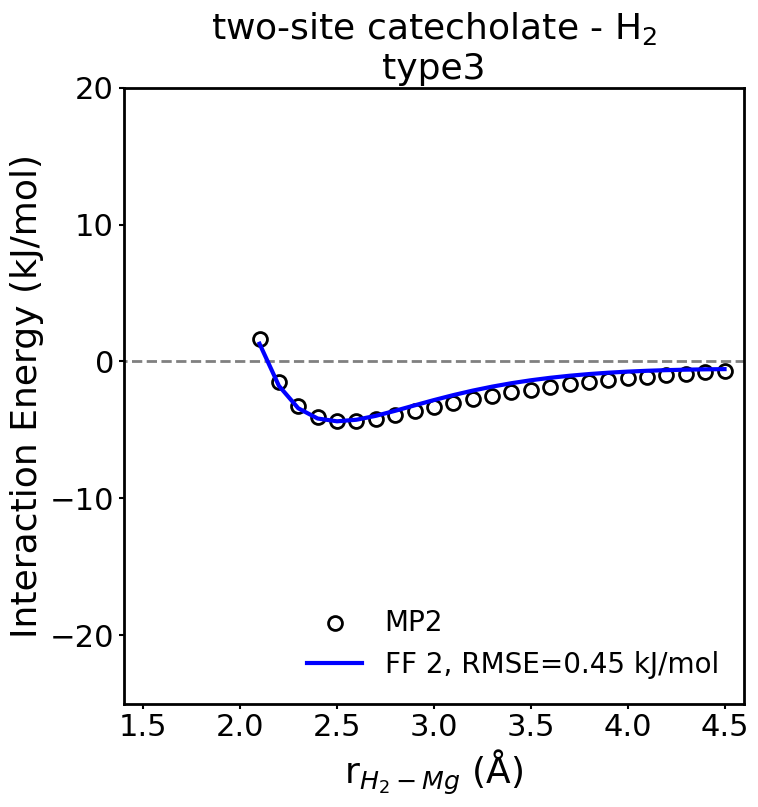

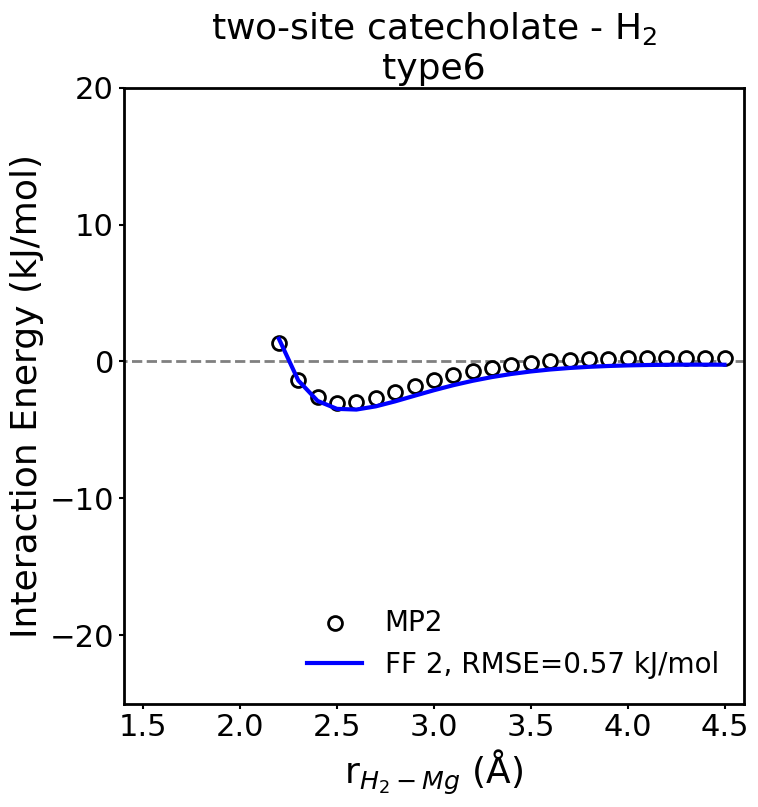

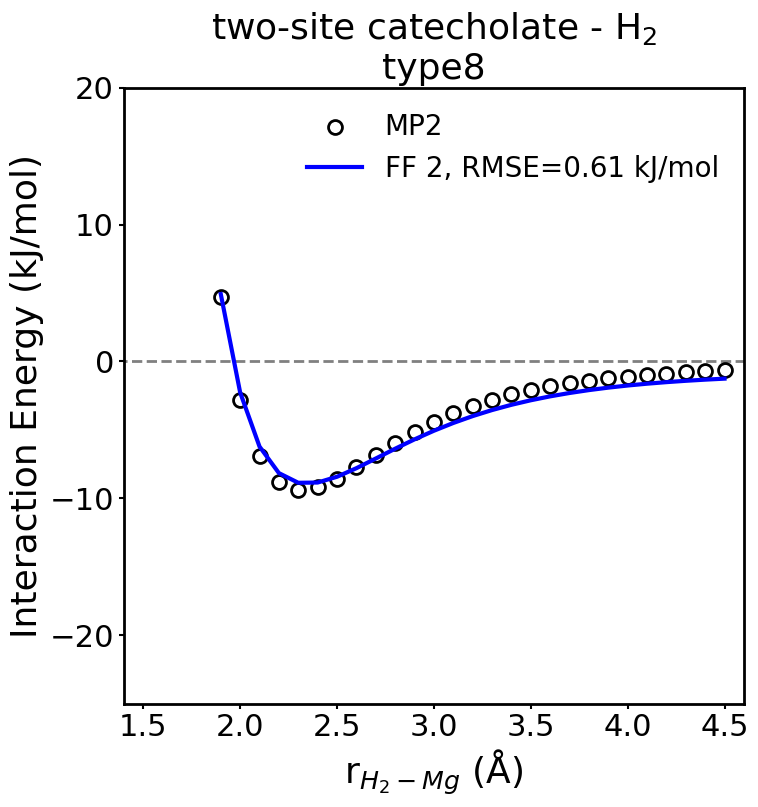

In [14]:
# Make comparison figures
for type_index in [0,1,2,3,6,8]:
    fig,ax = plt.subplots(figsize=(8,8),facecolor='w')
    E_MP2_list1=[]
    E_MP2_list=[]
    E_FF_list_localmin=[]
    E_FF_list_YSH_1=[]
    E_FF_list_YSH_2=[]
    E_FF_list_s=[]
    dis_list1=[]
    dis_list=[]

    if type_index==3: left_index=22
    elif type_index==6: left_index=23
    elif type_index==8: left_index=20
    else: left_index=19
#     for conj_index in np.arange(left_index-1,46):
#         struc_name = 'type'+str(type_index)+'_'+str(conj_index)
#         E_MP2 = E_QM_all[E_QM_all['r'+str(type_index)]==(conj_index/10)]['E'+str(type_index)].values[0]
#         E_MP2_list1.append(E_MP2)

#         dis_list1.append(conj_index/10)
# #         if E_MP2<20: ax.text(conj_index/10,E_MP2-1,str(conj_index),ha='center',va='top')
#     ax.scatter(dis_list1,E_MP2_list1,c='salmon',edgecolor='k',s=100,linewidth=2,label='MP2 (used for fitting)',zorder=4)

#     ax.plot([2,2],[-30,30],c='salmon',ls=':',zorder=-1)
#     ax.plot([4.6,4.6],[-30,30],c='salmon',ls=':',zorder=-1)
    for conj_index in np.arange(left_index-1,46):
        struc_name = 'type'+str(type_index)+'_'+str(conj_index)
        E_MP2 = E_QM_all[E_QM_all['r'+str(type_index)]==(conj_index/10)]['E'+str(type_index)].values[0]
        E_LJ=xyz_file_E_LJ_all[xyz_file_E_LJ_all.struc_name==struc_name]['E_LJ_'+site_type].values[0]
        xyz_file_pwd=xyz_FILE_DIR_all+site_type+'_site/type'+str(type_index)+'/type'+str(type_index)+'_'+str(conj_index)+'.xyz'
        atom_info_list=atom_info_grep(xyz_file_pwd)
        atom_distance_info=atom_distance_calc(atom_info_list)
#         E_morse_localmin=system_morse_energy_calc(atom_distance_info,morse_params_localmin)
        E_morse_YSH_1=system_morse_energy_calc(atom_distance_info,morse_params_YSH_1)
        E_morse_YSH_2=system_morse_energy_calc(atom_distance_info,morse_params_YSH_2)
#         E_morse_s=system_morse_energy_calc(atom_distance_info,morse_params_s)
        E_MP2_list.append(E_MP2)
#         E_FF_list_localmin.append(E_LJ+E_morse_localmin)
        E_FF_list_YSH_1.append(E_LJ+E_morse_YSH_1)
        E_FF_list_YSH_2.append(E_LJ+E_morse_YSH_2)
#         E_FF_list_s.append(E_LJ+E_morse_s)
        dis_list.append(conj_index/10)
#         if E_MP2<20: ax.text(conj_index/10,E_MP2-1,str(conj_index),ha='center',va='top')
    ax.scatter(dis_list,E_MP2_list,c='w',edgecolor='k',s=100,linewidth=2,label='MP2',zorder=3)
#     ax.plot(dis_list,E_FF_list_localmin,c='orange',linewidth=3,label='localmin'
#             +", RMSE="+format(RMSE_cal(E_MP2_list,E_FF_list_localmin),'.2f')+" kJ/mol")
#     ax.plot(dis_list,E_FF_list_YSH_1,c='r',linewidth=3,label='FF 1'
#             +", RMSE="+format(RMSE_cal(E_MP2_list,E_FF_list_YSH_1),'.2f')+" kJ/mol",zorder=6)
#     ax.plot(dis_list,E_FF_list_YSH_1,c='r',linewidth=3,label='FF 1',zorder=6)
    ax.plot(dis_list,E_FF_list_YSH_2,c='b',linewidth=3,label='FF 2'
            +", RMSE="+format(RMSE_cal(E_MP2_list,E_FF_list_YSH_2),'.2f')+" kJ/mol",zorder=6)
#     ax.plot(dis_list,E_FF_list_s,'k--',linewidth=3,label='Ref'
#             +", RMSE="+format(RMSE_cal(E_MP2_list,E_FF_list_s),'.2f')+" kJ/mol",zorder=5)
#     ax.plot(dis_list,E_FF_list_s,'k--',linewidth=3,label='Ref',zorder=5)
    
    ax.plot([0,10],[0,0],'--',c='0.5',zorder=0,linewidth=2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.set_xlim([1.4,4.6])
    ax.set_ylim([-25,20])
    ax.set_xticks(np.arange(1.5,4.6,0.5))
    ax.set_yticks(np.arange(-20,21,10))
    ax.set_title(site_type+"-site catecholate - H$_{2}$\ntype"+str(type_index)
#                  +"RMSE="+format(RMSE_cal(E_MP2_list,E_FF_list),'.2f')+" kJ/mol\n"+
#                  "RMSE$_{ref}$="+format(RMSE_cal(E_MP2_list,E_FF_list_s),'.2f')+" kJ/mol"
                 ,fontsize=26)
    ax.set_ylabel("Interaction Energy (kJ/mol)",fontsize=26)
    ax.set_xlabel("r$_{H_2-Mg}$ (Å)",fontsize=26)
    ax.tick_params(axis='both', which='both', direction='out', labelsize=22,width=1.5)
    if type_index==0 or type_index==1 or type_index==2 or type_index==8:
        ax.legend(frameon=False,loc='upper right',fontsize=20)
    else: ax.legend(frameon=False,loc='lower right',fontsize=20)
    plt.savefig("./figures/new_20230321_comp/"+site_type+"_"+"O-Mg-O_type"+str(type_index)+".jpg",dpi=600,bbox_inches = 'tight')
    plt.show()


## Other Figures

### 1

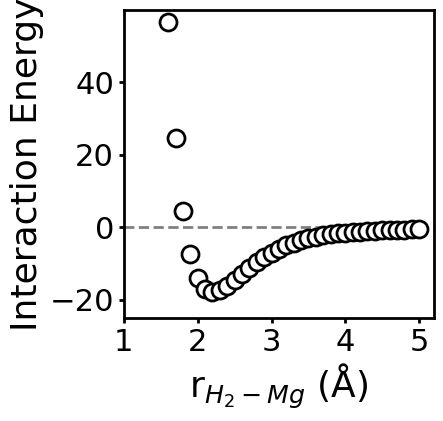

In [107]:
# Make comparison figures
range_type=[1]
for type_index in range_type:
    fig,ax = plt.subplots(figsize=(4,4),facecolor='w')
    E_MP2_list=[]
    dis_list=[]
    for conj_index in np.arange(15,51):
        struc_name = 'type'+str(type_index)+'_'+str(conj_index)
        E_MP2 = E_QM_all[E_QM_all['r'+str(type_index)]==(conj_index/10)]['E'+str(type_index)].values[0]
        E_MP2_list.append(E_MP2)
        dis_list.append(conj_index/10)
#         if E_MP2<20: ax.text(conj_index/10,E_MP2-1,str(conj_index),ha='center',va='top')
    ax.scatter(dis_list,E_MP2_list,c='w',edgecolor='k',s=150,linewidth=2,label='MP2')
    
    ax.plot([0,10],[0,0],'--',c='0.5',zorder=0,linewidth=2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.set_xlim([1,5.2])
    ax.set_ylim([-25,60])
    ax.set_xticks(np.arange(1,5.1,1))
    ax.set_yticks(np.arange(-20,60,20))
#     ax.set_title(site_type+"-site catecholate - H$_{2}$\ntype"+str(type_index)
# #                  +"RMSE="+format(RMSE_cal(E_MP2_list,E_FF_list),'.2f')+" kJ/mol\n"+
# #                  "RMSE$_{ref}$="+format(RMSE_cal(E_MP2_list,E_FF_list_s),'.2f')+" kJ/mol"
#                  ,fontsize=26)
    ax.set_ylabel("Interaction Energy",fontsize=26)
    ax.set_xlabel("r$_{H_2-Mg}$ (Å)",fontsize=26)
    ax.tick_params(axis='both', which='both', direction='out', labelsize=22,width=2)
#     if type_index==0 or type_index==1 or type_index==2 or type_index==8:
#         ax.legend(frameon=False,loc='upper right',fontsize=20)
#     else: ax.legend(frameon=False,loc='lower right',fontsize=20)
#     plt.savefig("./figures/new_20230208_comp/O-Mg-O_type"+str(type_index)+"_"+site_type+"_.jpg",dpi=600,bbox_inches = 'tight')
    plt.show()


### 2

In [26]:
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import spearmanr

In [27]:
# Calculate the RMSE between two list (two set of numbers)
def RMSE_cal(list1,list2):
    if len(list1)==len(list2):
        sum_up=0
        for i in range(len(list1)):
            sum_up+=((list1[i]-list2[i])**2)
        return np.sqrt(sum_up/len(list1))

In [28]:
site_type='two' # Difine the functionalized catecholate type, 'single' or 'two'

# Loading the Binding Energy information
E_QM_all = pd.read_excel('../Energy.xlsx',sheet_name=site_type+'_MP2') # Binding energy calculated by MP2 
xyz_file_E_LJ_all=pd.read_csv('E_LJ_all.csv') # Binding energy calculated by LJ+Coulomb potential models
xyz_file_list=xyz_file_E_LJ_all.struc_name.values.tolist() # list of the XYZ files
xyz_FILE_DIR_all='data/' # XYZ files of different configurations (H2 + catecholate)

In [63]:
# # YSH fitting result - single site
# solution_YSH_1=[835.09, 2.014, 2.214, 
#                 10, 3.862, 2,
#                 10.021, 1.015, 4.986]
# # YSH fitting result - two site
# solution_YSH_2=[641.414, 2.07, 2.249,
#                 10, 0.33, 8,
#                 10, 1.368, 4.3]

# if site_type == 'single': solution_std=solution_YSH_1
# elif site_type == 'two': solution_std=solution_YSH_2

In [33]:
# YSH fitting result - single site
solution_YSH_1=[910.1968652989739, 2.026770474665754, 2.2419952832116534,
                             28.628957031088127, 1.490137522531744, 3.8247121953956147,
                             1.0, 0.9305262547714995, 6.334574721981655]
# YSH fitting result - two site
solution_YSH_2=[801.0513010450125, 2.0542600327586786, 2.25735546137502,
                             30.059414611273834, 1.5145475990264539, 3.7782548024240024,
                             1.0, 0.9116553908710805, 6.399412118481408]

if site_type == 'single': solution_std=solution_YSH_1
elif site_type == 'two': solution_std=solution_YSH_2

In [32]:
RMSE_params_list(solution_ref)

1.485123219316029

In [34]:
solution_ref=[634.194, 2.055, 2.305, 
          13.567, 0.597, 6.336, 
          23.837, 1.321, 3.738]

In [41]:
def RMSE_params_list(solution_temp):
    morse_params_Mg=[solution_temp[0],solution_temp[1],solution_temp[2]]
    morse_params_C=[solution_temp[3],solution_temp[4],solution_temp[5]]
    morse_params_O=[solution_temp[6],solution_temp[7],solution_temp[8]]
    morse_params_temp=[morse_params_Mg, morse_params_C, morse_params_O]
    return RMSE(morse_params_temp)

In [42]:
dev=101
# D_min, D_max = 0.0, 1000.0
# a_min, a_max = 0.0, 5.0
# r_s_min, r_s_max = 0.0, 10.0

D_range_list=np.linspace(D_min,D_max,dev).tolist()
a_range_list=np.linspace(a_min, a_max,dev).tolist()
r_s_range_list=np.linspace(r_s_min, r_s_max,dev).tolist()

#### All 9 types

In [43]:
Err_list_Mg=[[],[],[]]
Err_list_C=[[],[],[]]
Err_list_O=[[],[],[]]
Err_list_all=[Err_list_Mg,Err_list_C,Err_list_O]

for atom_index in range(3):
    for params_comb_index in range(3):
        
        morse_params_Mg=[solution_std[0],solution_std[1],solution_std[2]]
        morse_params_C=[solution_std[3],solution_std[4],solution_std[5]]
        morse_params_O=[solution_std[6],solution_std[7],solution_std[8]]
        morse_params_temp=[morse_params_Mg, morse_params_C, morse_params_O]
        
        if params_comb_index==0: 
            params_index_1,params_index_2=0,1#D-a
            param_range_list_1=D_range_list
            param_range_list_2=a_range_list
        elif params_comb_index==1: 
            params_index_1,params_index_2=0,2 #D-r
            param_range_list_1=D_range_list
            param_range_list_2=r_s_range_list
        elif params_comb_index==2: 
            params_index_1,params_index_2=1,2 #a-r
            param_range_list_1=a_range_list
            param_range_list_2=r_s_range_list
            
        Err_list=np.zeros((dev,dev))
        for index_1 in np.arange(dev):
            morse_params_temp[atom_index][params_index_1]=param_range_list_1[index_1] 
            for index_2 in np.arange(dev):
                morse_params_temp[atom_index][params_index_2]=param_range_list_2[index_2] 
                Err_list[index_1][index_2]=RMSE(morse_params_temp)
        #             print(RMSE)
        Err_list_all[atom_index][params_comb_index]=Err_list

In [142]:
Err_list_all_single_r=Err_list_all

In [78]:
Err_list_all_two_100=Err_list_all

In [38]:
Err_list_all_two=Err_list_all

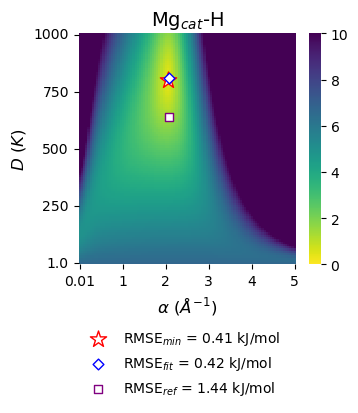

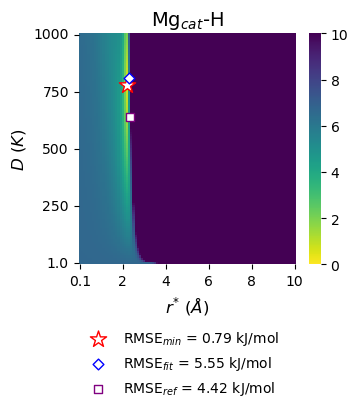

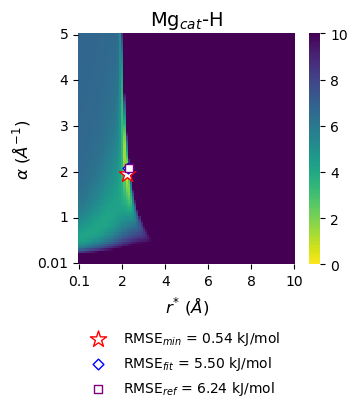

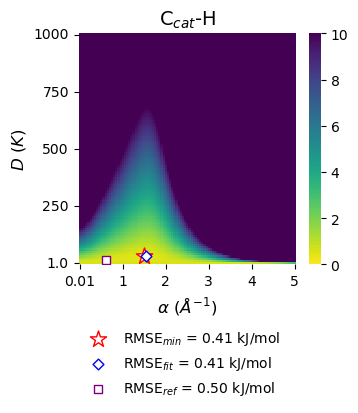

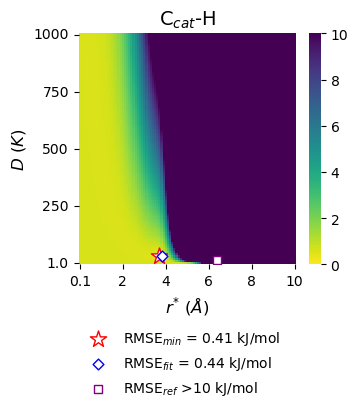

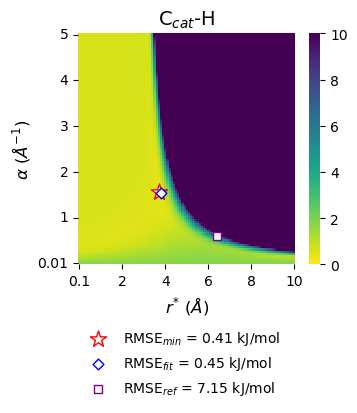

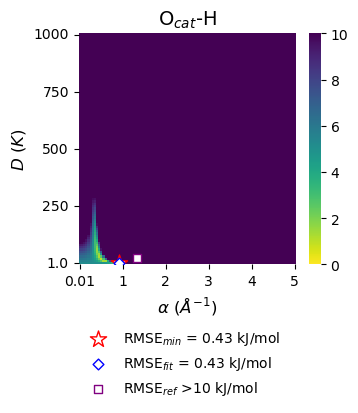

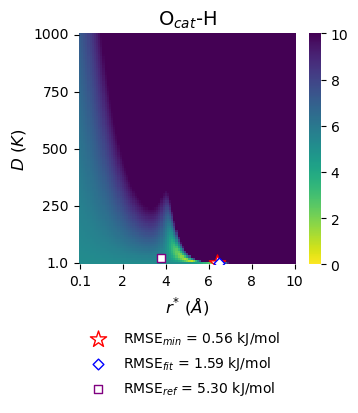

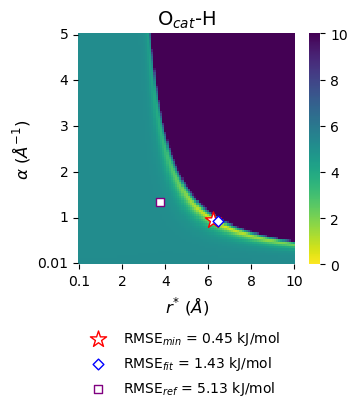

In [45]:
for atom_index in range(3):
    for params_comb_index in range(3):
        Err_list_temp=Err_list_all[atom_index][params_comb_index]
        fig,ax = plt.subplots(figsize=(3.5,3),facecolor='w')
        # ax.imshow(Err_list_Mg_D_a, vmin=0, vmax=30, cmap='viridis_r')
        sns.heatmap(Err_list_temp,  vmin=0, vmax=10,cmap='viridis_r')
        min_l=np.where(Err_list_temp==np.amin(Err_list_temp))
#         max_l=np.where(Err_list_temp==np.amax(Err_list_temp))

        if params_comb_index==0:
            min_x=a_range_list[min_l[1][0]]
            min_y=D_range_list[min_l[0][0]]
        elif params_comb_index==1:
            min_x=r_s_range_list[min_l[1][0]]
            min_y=D_range_list[min_l[0][0]]
        elif params_comb_index==2:
            min_x=r_s_range_list[min_l[1][0]]
            min_y=a_range_list[min_l[0][0]]

        RMSE_local=format(np.amin(Err_list_temp),'.2f')
        ax.scatter(min_l[1][0]+0.5,min_l[0][0]+0.5,marker='*',color='w',edgecolor='r',s=150,zorder=4,
                  label='RMSE$_{min}$ = '+RMSE_local+' kJ/mol')
        props = dict(boxstyle='round', facecolor='w', alpha=0.8)
#         ax.text(98,98,'min point: ('+format(min_x,'.2f')+','+format(min_y,'.2f')+')',va='top',ha='right',bbox=props)
#         ax.text(min_l[1][0]+0.5,min_l[0][0]+0.5,np.amin(Err_list_temp))
        if atom_index ==0: 
            if params_comb_index==0:
                fit_result_x=solution_std[1]/a_max*dev
                fit_result_y=solution_std[0]/D_max*dev
                fit_result_x_ref=solution_ref[1]/a_max*dev
                fit_result_y_ref=solution_ref[0]/D_max*dev
            elif params_comb_index==1:
                fit_result_x=solution_std[2]/r_s_max*dev
                fit_result_y=solution_std[0]/D_max*dev
                fit_result_x_ref=solution_ref[2]/r_s_max*dev
                fit_result_y_ref=solution_ref[0]/D_max*dev
            elif params_comb_index==2:
                fit_result_x=solution_std[2]/r_s_max*dev
                fit_result_y=solution_std[1]/a_max*dev
                fit_result_x_ref=solution_ref[2]/r_s_max*dev
                fit_result_y_ref=solution_ref[1]/a_max*dev
        elif atom_index ==1: 
            if params_comb_index==0:
                fit_result_x=solution_std[4]/a_max*dev
                fit_result_y=solution_std[3]/D_max*dev
                fit_result_x_ref=solution_ref[4]/a_max*dev
                fit_result_y_ref=solution_ref[3]/D_max*dev
            elif params_comb_index==1:
                fit_result_x=solution_std[5]/r_s_max*dev
                fit_result_y=solution_std[3]/D_max*dev
                fit_result_x_ref=solution_ref[5]/r_s_max*dev
                fit_result_y_ref=solution_ref[3]/D_max*dev
            elif params_comb_index==2:
                fit_result_x=solution_std[5]/r_s_max*dev
                fit_result_y=solution_std[4]/a_max*dev
                fit_result_x_ref=solution_ref[5]/r_s_max*dev
                fit_result_y_ref=solution_ref[4]/a_max*dev
        elif atom_index ==2: 
            if params_comb_index==0:
                fit_result_x=solution_std[7]/a_max*dev
                fit_result_y=solution_std[6]/D_max*dev
                fit_result_x_ref=solution_ref[7]/a_max*dev
                fit_result_y_ref=solution_ref[6]/D_max*dev
            elif params_comb_index==1:
                fit_result_x=solution_std[8]/r_s_max*dev
                fit_result_y=solution_std[6]/D_max*dev
                fit_result_x_ref=solution_ref[8]/r_s_max*dev
                fit_result_y_ref=solution_ref[6]/D_max*dev
            elif params_comb_index==2:
                fit_result_x=solution_std[8]/r_s_max*dev
                fit_result_y=solution_std[7]/a_max*dev
                fit_result_x_ref=solution_ref[8]/r_s_max*dev
                fit_result_y_ref=solution_ref[7]/a_max*dev
        RMSE_fit=format(Err_list_temp[round(fit_result_y)][round(fit_result_x)],'.2f')
        RMSE_ref=format(Err_list_temp[round(fit_result_y_ref)][round(fit_result_x_ref)],'.2f')
        ax.scatter(fit_result_x+0.5,fit_result_y+0.5,marker='D',color='w',edgecolor='b',s=30,zorder=5,
                   label='RMSE$_{fit}$ = '+RMSE_fit+' kJ/mol')
        if Err_list_temp[round(fit_result_y_ref)][round(fit_result_x_ref)]>10.:
            ax.scatter(fit_result_x_ref+0.5,fit_result_y_ref+0.5,marker='s',color='w',edgecolor='purple',s=30,zorder=5,
                  label='RMSE$_{ref}$ >10 kJ/mol')
        else:
            ax.scatter(fit_result_x_ref+0.5,fit_result_y_ref+0.5,marker='s',color='w',edgecolor='purple',s=30,zorder=5,
                  label='RMSE$_{ref}$ = '+RMSE_ref+' kJ/mol')
        
#         ax.text(fit_result_x+0.5,fit_result_y+0.5,
#                 RMSE(morse_params_std))

        ax.set_xlim(0,dev)
        ax.set_ylim(0,dev)
        if atom_index ==0: atom_pair="Mg$_{cat}$-H"
        elif atom_index ==1: atom_pair="C$_{cat}$-H"
        elif atom_index ==2: atom_pair="O$_{cat}$-H"
        ax.set_title(atom_pair,fontsize=14)
        ax.legend(frameon=False,loc=[0,-0.6],fontsize=10)
        if params_comb_index==0:
            ax.set_xticks(np.linspace(0.5,dev-0.5,6), [a_min,1,2,3,4,5],rotation=0)
            ax.set_yticks(np.linspace(0.5,dev-0.5,5), [D_min,250,500,750,1000],rotation=0)
#             ax.set_xticks(np.linspace(0.5,dev-0.5,6), np.linspace(a_min,a_max,6),rotation=45)
#             ax.set_yticks(np.linspace(0.5,dev-0.5,5), np.linspace(D_min,D_max,5),rotation=0)
            ax.set_xlabel(r'$\alpha$ ($\AA^{-1}$)',fontsize=12)
            ax.set_ylabel(r'$D$ ($K$)',fontsize=12)
        elif params_comb_index==1:
            ax.set_xticks(np.linspace(0.5,dev-0.5,6), [r_s_min,2,4,6,8,10],rotation=0)
            ax.set_yticks(np.linspace(0.5,dev-0.5,5), [D_min,250,500,750,1000],rotation=0)
            ax.set_xlabel(r'$r^{*}$ ($\AA$)',fontsize=12)
            ax.set_ylabel(r'$D$ ($K$)',fontsize=12)
        elif params_comb_index==2:
            ax.set_xticks(np.linspace(0.5,dev-0.5,6), [r_s_min,2,4,6,8,10],rotation=0)
            ax.set_yticks(np.linspace(0.5,dev-0.5,6), [a_min,1,2,3,4,5],rotation=0)
            ax.set_xlabel(r'$r^{*}$ ($\AA$)',fontsize=12)
            ax.set_ylabel(r'$\alpha$ ($\AA^{-1}$)',fontsize=12)
        plt.savefig("./figures/sensitivity_an_20230302/pure_"+site_type+"_"+str(atom_index)+"_"+str(params_comb_index)+".jpg",
                    dpi=600,bbox_inches = 'tight')
        plt.show()
    
        

In [116]:
solution_localmin=[645, 2.1, 2.2,
                  10,0.35,8.2,
                  10,1.35,4.3]

RMSE_params_list(solution_localmin)

1.149982487841514

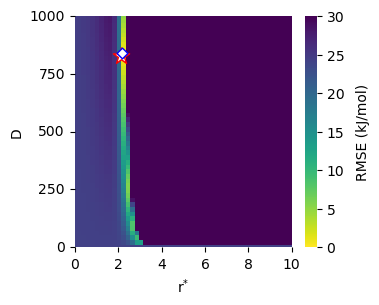

In [527]:
Err_list_temp=Err_list_all[0][1]
fig,ax = plt.subplots(figsize=(3.5,3),facecolor='w')

sns.heatmap(Err_list_Mg_D_r_s,  vmin=0, vmax=30,  cmap='viridis_r')
min_l=np.where(Err_list_Mg_D_r_s==np.amin(Err_list_Mg_D_r_s))
ax.scatter(min_l[1][0],min_l[0][0],marker='*',color='w',edgecolor='r',s=150)
ax.scatter(solution_std[2]/r_s_max*dev,solution_std[0]/D_max*dev,marker='D',color='w',edgecolor='b',s=30)
ax.text(64,25,"RMSE (kJ/mol)",va='center',rotation=90)
ax.set_xlim(0.5,49.5)
ax.set_ylim(0.5,49.5)
ax.set_xticks(np.linspace(0.5,49.5,6), [0,2,4,6,8,10],rotation=0)
ax.set_yticks(np.linspace(0.5,49.5,5), [0,250,500,750,1000],rotation=0)
ax.set_xlabel("r$^{*}$")
ax.set_ylabel("D")
# ax.invert_yaxis()
plt.show()

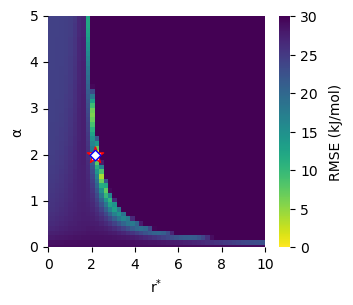

In [526]:
fig,ax = plt.subplots(figsize=(3.5,3),facecolor='w')

sns.heatmap(Err_list_Mg_a_r_s, vmin=0, vmax=30, cmap='viridis_r')
min_l=np.where(Err_list_Mg_a_r_s==np.amin(Err_list_Mg_a_r_s))
ax.scatter(min_l[1][0],min_l[0][0],marker='*',color='w',edgecolor='r',s=150)
ax.scatter(solution_std[2]/r_s_max*dev,solution_std[1]/a_max*dev,marker='D',color='w',edgecolor='b',s=30)

ax.text(64,25,"RMSE (kJ/mol)",va='center',rotation=90)

ax.set_xlim(0.5,49.5)
ax.set_ylim(0.5,49.5)
ax.set_xticks(np.linspace(0.5,49.5,6), [0,2,4,6,8,10],rotation=0)
ax.set_yticks(np.linspace(0.5,49.5,6), [0,1,2,3,4,5],rotation=0)
ax.set_xlabel("r$^{*}$")
ax.set_ylabel("α")
# ax.invert_yaxis()
plt.show()